In [1]:
import warnings
import hazm
import re
import time
import ast
import random
import pandas as pd

from hazm import stopwords_list
from hazm import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from cleantext import clean

from tqdm import tqdm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from wordcloud_fa import WordCloudFa

from stopwords_guilannlp import stopwords_output

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
tqdm.pandas()

# Data Reading

In [3]:
base_path = "../data/"

input_file = base_path + "remote_tweets.csv"
emojies_file = base_path + "emojies.txt"

In [4]:
contextual_cols = ['tweet', 'hashtags']
tweets_df = pd.read_csv(input_file, low_memory=False, usecols=contextual_cols)
tweets_df.head(20)

tweet  \
0   ÿ®Ÿá ŸÖŸÜ ⁄Øÿ≤ÿßÿ±ÿ¥ ŸÖ€åÿØŸá ÿ≠ŸÇŸàŸÇÿ¥ ŸÖ€åÿØŸàŸÜŸÖ ÿ≥ÿßŸÑ€å €∏€µÿ™ÿßÿå ŸáŸÖÿ≥ÿ±ÿ¥...   
1   ÿß€åŸÜÿß€å€å ⁄©Ÿá ÿ±ŸÅÿ™ŸÜ ÿ≥ŸÅÿ±ÿå ŸÖŸáŸÖŸàŸÜ€å Ÿà... Ÿá€å⁄Ü Ÿæÿ±Ÿàÿ™⁄©ŸÑ€å ŸáŸÖ...   
2   ÿØÿßÿ±ŸÖ ŸÅ⁄©ÿ± ŸÖ€å⁄©ŸÜŸÖ ⁄©Ÿá ⁄ÜŸÇÿØÿ± ÿÆÿ≥ÿ™Ÿá ÿßŸÖ ÿ®ÿß ÿß€åŸÜ⁄©Ÿá ÿßŸÖÿ±Ÿàÿ≤ ...   
3    €å⁄© ÿ≥ÿßŸÑ Ÿà ŸÜ€åŸÖŸá  ÿßÿ≤ ŸÇÿ®ŸÑ ÿ¢ÿ®ÿßŸÜ €π€∏ ÿØŸàÿ±⁄©ÿßÿ± ÿ¥ÿØŸÖ ÿ™ÿß ÿßŸÑÿßŸÜ   
4   @shahrzaad ÿ≠ÿ™ŸÖŸÜ ŸÖ€åÿ±ŸÅÿ™ŸÖ ÿ®Ÿá ÿ¥Ÿáÿ±€å ⁄©Ÿá ÿ®Ÿá ÿßŸÇŸàÿßŸÖ €åÿß ...   
5   ÿØŸàÿ±⁄©ÿßÿ±€å €åÿß ⁄©ÿßÿ± ÿßÿ≤ ÿÆŸàŸÜŸá ÿÆ€åŸÑ€å ÿ®ÿ±ÿßŸÖ ŸÅÿ±ÿ≥ÿß€åÿ¥€å ÿ¥ÿØŸá ÿØ...   
6   @ehsan_bz ÿ™Ÿà ÿ®ÿÆÿ¥‚ÄåŸáÿß€å ÿØ€å⁄ØŸá ŸÜŸÖ€å‚ÄåÿØŸàŸÜŸÖ ŸàŸÑ€å ÿ®ÿÆÿ¥ ŸÅŸÜ€å...   
7   @Klaus5566 @sara90059240 ŸÖÿß€å ÿ®ÿØÿ®ÿÆÿ™ Ÿá€å⁄ÜŸàŸÇÿ™ ÿØŸàÿ±⁄©...   
8   @JabbariForouq @Steppenwolf1989 ÿßÿÆŸá ŸÖÿ¥⁄©ŸÑ ÿπÿØŸÖ Ÿá...   
9   ŸÖŸÜ ÿ™ÿ±ÿ¨€åÿ≠ ŸÖ€åÿØŸÖ ÿßÿ≤ #⁄©ÿ±ŸàŸÜÿß ÿ®ŸÖ€åÿ±ŸÖ ÿ™ÿß ÿßÿ≤ #ÿØŸàÿ±⁄©ÿßÿ±€å.....   
10  ÿßÿÆÿ®ÿßÿ± ÿµÿØÿßŸà ÿ≥€åŸÖÿß  :  ÿ™Ÿáÿ±ÿßŸÜ ÿåŸÇÿ±ŸÖÿ≤ ÿå ÿØŸàÿ±⁄©ÿßÿ±€å ÿå ÿ™ÿπ...   
11  @Tamcat1349 ÿÆ€åŸÑ€å ÿßÿ≤ ÿßÿ±⁄ØÿßŸÜŸáÿß ÿ®ÿ±ÿß€å ÿØŸàÿ±⁄©ÿßÿ±€å ŸÇŸàÿßŸÜ€å...   
12  ÿßÿØÿßÿ±Ÿá ÿØŸàÿ±⁄©ÿßÿ±€å ÿ¥ÿØ ÿå ŸáŸÖ⁄©ÿßÿ±ÿß ÿØŸà ÿ±Ÿàÿ≤ ÿ¢ŸÅ ÿØÿ± ŸáŸÅÿ™Ÿá ÿ±Ÿà...   
13  ÿµÿ®ÿ≠ ÿ®ÿßÿ®ÿßŸÖ ÿßŸàŸÖÿØ ⁄ØŸÅÿ™ Ÿæÿßÿ¥Ÿà ÿ®ÿß€åÿØ ÿ®ÿ±€å ÿ≥ÿ±⁄©ÿßÿ± ÿÆŸàÿßÿ≥ÿ™ŸÖ ...   
14  @OHANZEEnm üòîüòîüòîŸáÿπÿπÿπÿπ€å ŸÖÿß ŸáŸÖ €åÿ±Ÿàÿ≤ ÿØŸàÿ±⁄©ÿßÿ± ŸÖ€åÿ¥€åŸÖ Ÿà...   
15  ⁄ÜŸàŸÜ ⁄©ÿ≥€å ÿ®Ÿá ŸÅ⁄©ÿ± ŸÖÿß ŸÜ€åÿ≥ÿ™ÿå ÿßÿ≤ ÿßŸÖÿ±Ÿàÿ≤ ŸÖÿß ⁄Øÿ±ŸàŸá ⁄©Ÿà⁄Ü€å⁄©...   
16  ÿ®ÿßÿ≤ ŸÖŸÜ ÿ±Ÿàÿ≤Ÿáÿß€å ŸáŸÅÿ™Ÿá ÿ±Ÿà ŸÇÿßÿ∑€å ⁄©ÿ±ÿØŸÖ.  ÿµÿ®ÿ≠ ÿÆŸàÿßÿ® ŸÖŸàŸÜ...   
17   €å⁄©ŸÖ ÿØ€å⁄ØŸá ÿØŸàÿ±⁄©ÿßÿ±€å ÿßÿØÿßŸÖŸá Ÿæ€åÿØÿß ⁄©ŸÜŸá ÿ≤ÿÆŸÖ ÿ®ÿ≥ÿ™ÿ± ŸÖ€å‚Äå⁄Ø€åÿ±ŸÖ   
18  @MAni_cactus_57 ÿß€åŸÜ ⁄©ÿßÿ± ÿØÿ± ÿÆÿßŸÜŸá ÿÆ€åŸÑ€å ŸáŸÖ ÿπÿßŸÑ€åÿ≥ÿ™...   
19  ⁄©ÿßÿ¥ ŸáŸÖ⁄©ÿßÿ±ÿß ÿ®ŸÅŸáŸÖŸÜ ÿØŸàÿ±⁄©ÿßÿ±€å ÿ®Ÿá ŸÖÿπŸÜ€å ŸÖÿ±ÿÆÿµ€å ŸÜ€åÿ≥ÿ™ ⁄©ÿß...   

                         hashtags  
0                             NaN  
1                             NaN  
2                             NaN  
3                             NaN  
4                             NaN  
5                             NaN  
6                             NaN  
7                             NaN  
8                             NaN  
9   ['⁄©ÿ±ŸàŸÜÿß', 'ÿØŸàÿ±⁄©ÿßÿ±€å', 'Ÿàÿß⁄©ÿ≥ŸÜ']  
10                      ['⁄©ÿ±ŸàŸÜÿß']  
11                            NaN  
12                            NaN  
13                            NaN  
14                            NaN  
15       ['Ÿàÿß⁄©ÿ≥ŸÜ_ÿ®ÿÆÿ±€åÿØ', '⁄©ÿ±ŸàŸÜÿß']  
16                            NaN  
17                            NaN  
18                            NaN  
19                            NaN

# Data Pre-processing

## Duplicate chars/emojies

In [5]:
emojies_content = open(base_path + 'emojies.txt',  encoding="utf8")
emojies = list(line.strip() for line in emojies_content)
emojies_str = ' '.join(e for e in emojies)
duplicate_emojies_pattern = "(?P<char>[" + re.escape(emojies_str) + "])(?P=char)*"

In [6]:
def remove_duplicates(text) : 
    dups = re.finditer(r"(.)\1{2,}", text)
    dup_list = []
    for d in dups:
        dup_list.append(d.group())
    
    for d in dup_list:
        text = text.replace(d, d[0]) #reduce chars with 3 or more repeats in a row to 1
    
    text = re.sub(duplicate_emojies_pattern, r" \1 ", text) #reduce emoji repeats to 1 and separate it from other tokens
    return text

## Text cleaning

- Unicode errors
- URLs
- Phone numbers
- emails
- currency symbols
- useless punctuations and chars

In [7]:
punctuations_file = open(base_path + 'stop-words/punctuations.txt',  encoding="utf8")
punctuations = list(line.strip() for line in punctuations_file)

imp_punctuations_file = open(base_path + 'imp_punctuations.txt',  encoding="utf8")
imp_punctuation_str = ' '.join(e for e in imp_punctuations_file)
imp_punctuation_pattern = "(?P<char>[" + re.escape(imp_punctuation_str) + "])(?P=char)*"

conversational_to_normal = {
   '⁄©Ÿàÿ±ŸàŸÜÿß': "⁄©ÿ±ŸàŸÜÿß",
    'ÿÆŸàŸÜŸá': "ÿÆÿßŸÜŸá",
    'ÿ™ŸÖŸàŸÖ': "ÿ™ŸÖÿßŸÖ",
    '⁄©ÿ±ŸàŸÜÿß€å': "⁄©ÿ±ŸàŸÜÿß",
    'ÿßŸÖÿ±€å⁄©ÿß': "ÿ¢ŸÖÿ±€å⁄©ÿß",
    'ÿßŸÜŸÑÿß€åŸÜ': "ÿ¢ŸÜŸÑÿß€åŸÜ",
}

same_concept = {
    "ÿØŸàÿ±⁄©ÿßÿ±": "ÿØŸàÿ±⁄©ÿßÿ±€å",    
}

space_list = ['_', '\s+']

useless_chars = re.compile("["
        # u"\U0001F600-\U0001F64F"  # emoticons
        # u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        # u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        # u"\U0001f926-\U0001f937"
        # u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)


In [8]:
pd.options.display.max_colwidth = 500
t = tweets_df.loc[[7]].tweet
print(t)

7    @Klaus5566 @sara90059240 ŸÖÿß€å ÿ®ÿØÿ®ÿÆÿ™ Ÿá€å⁄ÜŸàŸÇÿ™ ÿØŸàÿ±⁄©ÿßÿ±€å ŸÜÿØÿßÿ¥ÿ™€åŸÖ.ŸÖŸÜ ⁄©ÿ±ŸàŸÜÿß ⁄Øÿ±ŸÅÿ™ŸÖ ŸÅŸÇÿ∑ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿ®ŸáŸÖ ŸÖÿ±ÿÆÿµ€å ÿØÿßÿØŸÜ.Ÿá€åÿ¥⁄©€å ÿ≠ŸÇ ŸÜÿØÿßÿ¥ÿ™ ÿ®⁄ØŸá ŸÖŸÜ ŸÖÿ±€åÿ∂ŸÖ.ÿ™ÿßÿ≤Ÿá ÿ®ÿπÿØÿ¥ ⁄© ŸÖÿ±ÿÆÿµ€å ÿ™ŸÖŸàŸÖ ÿ¥ÿØ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿßÿ≤ ÿß€åŸÜ ÿ≥ÿßÿÆÿ™ŸÖŸàŸÜ ÿ®ÿßŸàŸÜ ÿ≥ÿßÿÆÿ™ŸÖŸàŸÜ ⁄©Ÿá ÿ®€åŸÖŸá ÿß€åÿßŸÖ ŸÖÿ±€åÿ∂€åÿ™Ÿà ÿ®ÿß ⁄©ÿ≥ÿ± ÿØŸà€åÿ≥ÿ™ ÿ≥€åÿµÿØ ÿ™ŸàŸÖŸÜ ÿ®Ÿáÿ™ ÿ®ÿØŸÜ
Name: tweet, dtype: object


In [9]:
#re.sub('(^|[^@\\w])@(\\w{1,15})\\b','', t.to_string())
#t = t.to_string()
#str(t).strip()
clean(t,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=True,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
        replace_with_punct = " "
    )

'7 klaus5566 sara90059240 ŸÖÿß€å ÿ®ÿØÿ®ÿÆÿ™ Ÿá€å⁄ÜŸàŸÇÿ™ ÿØŸàÿ±⁄©ÿßÿ±€å ŸÜÿØÿßÿ¥ÿ™€åŸÖ ŸÖŸÜ ⁄©ÿ±ŸàŸÜÿß ⁄Øÿ±ŸÅÿ™ŸÖ ŸÅŸÇÿ∑ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿ®ŸáŸÖ ŸÖÿ±ÿÆÿµ€å ÿØÿßÿØŸÜ Ÿá€åÿ¥⁄©€å ÿ≠ŸÇ ŸÜÿØÿßÿ¥ÿ™ ÿ®⁄ØŸá ŸÖŸÜ ŸÖÿ±€åÿ∂ŸÖ ÿ™ÿßÿ≤Ÿá ÿ®ÿπÿØÿ¥ ⁄© ŸÖÿ±ÿÆÿµ€å ÿ™ŸÖŸàŸÖ ÿ¥ÿØ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿßÿ≤ ÿß€åŸÜ ÿ≥ÿßÿÆÿ™ŸÖŸàŸÜ ÿ®ÿßŸàŸÜ ÿ≥ÿßÿÆÿ™ŸÖŸàŸÜ ⁄©Ÿá ÿ®€åŸÖŸá ÿß€åÿßŸÖ ŸÖÿ±€åÿ∂€åÿ™Ÿà ÿ®ÿß ⁄©ÿ≥ÿ± ÿØŸà€åÿ≥ÿ™ ÿ≥€åÿµÿØ ÿ™ŸàŸÖŸÜ ÿ®Ÿáÿ™ ÿ®ÿØŸÜ name tweet dtype object'

In [10]:
def clean_html(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def clean_text(text, is_hashtag=False) :
    
    #@username (replies)
    text = re.sub('(^|[^@\\w])@(\\w{1,15})\\b','', text)
#     text = re.sub('@[^\s]+','', text)
#     text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text)    
    
    text = str(text).strip()
    
    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=True,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
        replace_with_punct = " ",
    )
        
    
    # HTML
    text = clean_html(text)
    
    # useless patterns
    text = useless_chars.sub(r'', text)
    
    # urls with http/https
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r"http\S+", '', text)

    # unncessary characters and punctuations
    if is_hashtag == False: # to keep underlines in hashtags
        for r in space_list:
            text = text.replace(r, ' ')
        
    for p in punctuations:
        text = text.replace(p, ' ')
    
    text = re.sub(imp_punctuation_pattern, r" \1 ", text)
    
    
    # conversational to normal form
    for key, value in conversational_to_normal.items():
        text.replace(key, value)
        
    text = re.sub(' +', ' ', text)
    
    #same concept
    for key, value in same_concept.items():
        text.replace(key, value)
    
#     print(f"after: {text}")
    return text

## Normalization

In [11]:
normalizer = hazm.Normalizer()

def get_normalization(text):
    return normalizer.normalize(text)

## Stop-words

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/parnian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
stop_words_fa = set(stopwords_list()) 
stop_words_en = set(stopwords.words('english'))

bullshitsFile = open(base_path + 'stop-words/bullshits.txt',  encoding="utf8")
charsFile = open(base_path + 'stop-words/chars.txt',  encoding="utf8")
infinitivesFile = open(base_path + 'stop-words/infinitives.txt',  encoding="utf8")
nonverbalFile = open(base_path + 'stop-words/nonverbal.txt',  encoding="utf8")
persianFile = open(base_path + 'stop-words/persian.txt',  encoding="utf8")
shortFile = open(base_path + 'stop-words/short.txt',  encoding="utf8")
verbalFile = open(base_path + 'stop-words/verbal.txt',  encoding="utf8")
kharaziFile = open(base_path + 'stop-words/kharazi-stopwords.txt',  encoding="utf8")
manualFile = open(base_path + 'stop-words/manual.txt',  encoding="utf8")


bullshits = set(line.strip() for line in bullshitsFile)
chars = set(line.strip() for line in charsFile)
infinitives = set(line.strip() for line in infinitivesFile)
nonverbal = set(line.strip() for line in nonverbalFile)
persian = set(line.strip() for line in persianFile)
short = set(line.strip() for line in shortFile)
verbal = set(line.strip() for line in verbalFile)

stop_words = stop_words_fa.union(stop_words_en)
stop_words = stop_words.union(punctuations)
stop_words = stop_words.union(bullshits)
stop_words = stop_words.union(chars)
stop_words = stop_words.union(infinitives)
stop_words = stop_words.union(nonverbal)
stop_words = stop_words.union(persian)
stop_words = stop_words.union(short)
stop_words = stop_words.union(verbal)

In [14]:
def remove_stopwords(text) :
    tokens = word_tokenize(text)
    tokens_without_sw = [word for word in tokens if not word in stop_words]
    text = " ".join([word for word in tokens_without_sw])
    return text

## Lemmatization

In [15]:
lemmatizer = hazm.Lemmatizer()

def lemmatize_tweet(text) : 
    return " ".join([lemmatizer.lemmatize(word).split('#')[0] for word in word_tokenize(text)])

## Cleaning Procedure

In [16]:
def clean_data(data_df, col_name) :
    data_df[col_name] = data_df[col_name].progress_apply(lambda t: clean_text(t, col_name == 'hashtags'))
    data_df[col_name] = data_df[col_name].progress_apply(lambda t: remove_duplicates(t))
    data_df[col_name] = data_df[col_name].progress_apply(lambda t: remove_stopwords(t))
    data_df[col_name + '_tokens'] = data_df[col_name].progress_apply(lambda t: word_tokenize(t))
    
    data_df['lemmatized_' + col_name] = data_df[col_name].progress_apply(lambda t: lemmatize_tweet(t)) 
    data_df['lemmatized_' + col_name] = data_df['lemmatized_' + col_name].progress_apply(lambda t: remove_stopwords(t))
    data_df['lemmatized_' + col_name + '_token'] = data_df['lemmatized_' + col_name].progress_apply(lambda t: word_tokenize(t))
    
    data_df[col_name + '_size'] = data_df[col_name + '_tokens'].progress_apply(lambda t: len(t))
    data_df['lemmatized_' + col_name + '_size'] = data_df['lemmatized_' + col_name + '_token'].progress_apply(lambda t: len(t))

In [17]:
clean_data(tweets_df, 'tweet')
tweets_df.head(10)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 45359/45359 [00:00<00:00, 1051264.48it/s]


tweet  \
0  ⁄Øÿ≤ÿßÿ±ÿ¥ ÿ≠ŸÇŸàŸÇÿ¥ ŸÖ€åÿØŸàŸÜŸÖ ÿ≥ÿßŸÑ€å €∏€µ ŸáŸÖÿ≥ÿ±ÿ¥ ÿØÿßŸÜÿ¥ÿ¨Ÿà ÿØ⁄©ÿ™ÿ±ÿß ÿ¥ÿ±⁄©ÿ™ ÿßÿ≠ÿ™ŸÖÿßŸÑŸÜ ŸÖÿ¥ÿßŸàÿ± ŸÖŸàÿ±⁄Øÿ¨ ÿ®ÿ±ÿßÿ¥ ŸÖÿØÿßÿ±⁄© ÿ≠ŸÇŸàŸÇ ÿØÿ±€åÿßŸÅÿ™€å ÿØÿ±ÿ≥ÿ™ ÿØÿ±ÿÆŸàÿßÿ≥ÿ™ ŸàÿßŸÖ €π€µ€∞ ÿ™ÿß€å€åÿ¥ ŸÇÿ®ŸàŸÑ ÿ±€åÿ≥⁄©ÿ¥ ÿ¨ÿßŸÑÿ® ŸÖÿ∑ŸÖ€åŸÜŸá ŸÇÿ±ÿßÿ±ÿØÿßÿØÿ¥ ÿ™ŸÖÿØ€åÿØ ŸÖ€åÿ¥Ÿá ⁄©ÿßÿ± ÿÆŸàŸÜŸá ÿßÿØÿßŸÖŸá ŸÖ€å⁄©ŸÜŸá   
1                                                                                                                      ÿß€åŸÜÿß€å€å ÿ≥ŸÅÿ± ŸÖŸáŸÖŸàŸÜ€å Ÿæÿ±Ÿàÿ™⁄©ŸÑ€å ÿ±ÿπÿß€åÿ™ ŸÜ⁄©ÿ±ÿØŸÜ ÿ≥ÿ±⁄©ÿßÿ± ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá ÿØŸàÿ±⁄©ÿßÿ± ÿ®ÿ¥€åŸÖ ÿ®Ÿáÿ™ÿ±Ÿá   
2          ÿÆÿ≥ÿ™Ÿá ÿØŸàÿ±⁄©ÿßÿ±€å ÿ¥Ÿáÿ±Ÿáÿß€å ÿ≥ÿ±ŸàÿµÿØÿß ÿ¥ÿ® ÿßÿ≤ÿµÿ®ÿ≠ ÿ¢ÿ≤ÿßÿ±ÿØŸáŸÜÿØŸá ÿ™ÿ±Ÿá ŸÜÿ®ŸàÿØŸÅÿ±ŸáŸÜ⁄Ø ÿ¥Ÿáÿ±ŸÜÿ¥€åŸÜ€å ÿ¢Ÿæÿßÿ±ÿ™ŸÖÿßŸÜ ŸÜÿ¥€åŸÜ€å ÿ®€åÿØÿßÿØ ŸÖ€å⁄©ŸÜŸá ŸáŸÖ⁄Ø€å ÿ±ÿπÿß€åÿ™ ŸáŸÖÿØ€å⁄Øÿ± ⁄Üÿßÿ±ÿØ€åŸàÿßÿ±€å ÿßÿÆÿ™€åÿßÿ±€å ŸÖÿ±ÿØŸÖÿØÿßÿ±€å ⁄ØŸàÿ¥Ÿá ÿßÿ≤ŸÅÿ±ŸáŸÜ⁄Ø Ÿàÿ¥ÿπŸàÿ± ŸàÿßŸÜÿ≥ÿßŸÜ€åÿ™Ÿá ÿ¥ÿ® ÿÆŸàÿ¥üåÉ   
3                                                                                                                                                                             ÿ¢ÿ®ÿßŸÜ €π€∏ ÿØŸàÿ±⁄©ÿßÿ±   
4                                                                                                 ÿ≠ÿ™ŸÖŸÜ ŸÖ€åÿ±ŸÅÿ™ŸÖ ÿ¥Ÿáÿ±€å ÿßŸÇŸàÿßŸÖ ÿØŸàÿ≥ÿ™ÿßŸÖ ŸÜÿ≤ÿØ€å⁄©ÿ™ÿ± ÿÆŸàŸÜŸá ÿßÿ¨ÿßÿ≤Ÿá ŸÖ€å⁄©ÿ±ÿØŸÖ ŸÅÿ±ÿµÿ™ ⁄©ÿßÿ± ŸÖŸÜÿ≤ŸÑ ÿµŸàÿ±ÿ™ ŸÖŸÖ⁄©ŸÜŸá ÿ™⁄©ÿ±ÿßÿ± ŸÜÿ¥Ÿá   
5                                                                                      ÿØŸàÿ±⁄©ÿßÿ±€å ⁄©ÿßÿ± ÿÆŸàŸÜŸá ÿ®ÿ±ÿßŸÖ ŸÅÿ±ÿ≥ÿß€åÿ¥€å ŸÖÿ≠€åÿ∑ ⁄©ÿßÿ±€å ÿ¢ÿØŸÖÿß ÿßÿ±ÿ™ÿ®ÿßÿ∑ ÿßŸÅÿ≥ÿ±ÿØŸá ÿ®ÿ±ŸÜÿßŸÖŸá ŸÜŸà€åÿ≥ÿß ÿß€åŸÜÿ∑Ÿàÿ±€å ŸÜ⁄ØÿßŸá ÿ≥ÿ±⁄©ÿßÿ± ÿÆŸàÿ¥ ŸÖ€å⁄Øÿ∞ÿ±Ÿá   
6                                                                                                                               ÿ®ÿÆÿ¥‚ÄåŸáÿß€å ŸÜŸÖ€å‚ÄåÿØŸàŸÜŸÖ ŸÅŸÜ€å ÿØŸàÿ±⁄©ÿßÿ±€å ÿ¨ÿßŸÜ€åŸÅÿ™ÿßÿØŸá ÿØŸàÿ≥ÿ™ ÿ≠ÿ∂Ÿàÿ± ÿØÿßÿ¥ÿ™Ÿá_ÿ®ÿßÿ¥€åŸÖ   
7                                                     ŸÖÿß€å ÿ®ÿØÿ®ÿÆÿ™ ÿØŸàÿ±⁄©ÿßÿ±€å ⁄©ÿ±ŸàŸÜÿß ⁄Øÿ±ŸÅÿ™ŸÖ ŸÖÿ±ÿÆÿµ€å Ÿá€åÿ¥⁄©€å ÿ≠ŸÇ ŸÖÿ±€åÿ∂ŸÖ ÿ™ÿßÿ≤Ÿá ÿ®ÿπÿØÿ¥ ŸÖÿ±ÿÆÿµ€å ÿ™ŸÖŸàŸÖ ÿ≥ÿßÿÆÿ™ŸÖŸàŸÜ ÿ®ÿßŸàŸÜ ÿ≥ÿßÿÆÿ™ŸÖŸàŸÜ ÿ®€åŸÖŸá ÿß€åÿßŸÖ ŸÖÿ±€åÿ∂€åÿ™Ÿà ⁄©ÿ≥ÿ± ÿØŸà€åÿ≥ÿ™ ÿ≥€åÿµÿØ ÿ™ŸàŸÖŸÜ ÿ®ÿØŸÜ   
8                                          ÿßÿÆŸá ŸÖÿ¥⁄©ŸÑ ŸáŸÖ⁄©ÿßÿ±€å ŸÖÿ≠ŸÑ ⁄©ÿßÿ± ÿßŸÅÿ±ÿßÿØŸá ŸÖÿ±ÿÆÿµ€å ŸÜŸÖ€åÿØŸÜ ŸáŸÖ⁄©ÿßÿ±ÿß ŸÜÿß⁄Üÿßÿ± ÿ≠ÿ∂Ÿàÿ±ŸÜÿØ ÿØÿ≥ÿ™Ÿàÿ± ÿØŸàÿ±⁄©ÿßÿ±€å ÿßÿ®ŸÑÿßÿ∫ ŸÖŸÇÿµÿ± ÿ≥€åÿ≥ÿ™ŸÖŸá ÿ™ÿπÿ∑€åŸÑ Ÿàÿß⁄©ÿ≥ŸÜ ŸÖ€åÿÆÿ±Ÿá ŸÜÿ∏ÿßÿ±ÿ™ ÿØŸÇ€åŸÇ ÿØÿ≥ÿ™Ÿàÿ±ÿßŸÑÿπŸÖŸÑŸáÿß€å ÿØŸàÿ±⁄©ÿßÿ±€å   
9                                                                                                                                                       ÿ™ÿ±ÿ¨€åÿ≠ ŸÖ€åÿØŸÖ ⁄©ÿ±ŸàŸÜÿß ÿ®ŸÖ€åÿ±ŸÖ ÿØŸàÿ±⁄©ÿßÿ±€å Ÿàÿß⁄©ÿ≥ŸÜ   

                        hashtags  \
0                            NaN   
1                            NaN   
2                            NaN   
3                            NaN   
4                            NaN   
5                            NaN   
6                            NaN   
7                            NaN   
8                            NaN   
9  ['⁄©ÿ±ŸàŸÜÿß', 'ÿØŸàÿ±⁄©ÿßÿ±€å', 'Ÿàÿß⁄©ÿ≥ŸÜ']   

                                                                                                                                                                                                                 tweet_tokens  \
0  [⁄Øÿ≤ÿßÿ±ÿ¥, ÿ≠ŸÇŸàŸÇÿ¥, ŸÖ€åÿØŸàŸÜŸÖ, ÿ≥ÿßŸÑ€å, €∏€µ, ŸáŸÖÿ≥ÿ±ÿ¥, ÿØÿßŸÜÿ¥ÿ¨Ÿà, ÿØ⁄©ÿ™ÿ±ÿß, ÿ¥ÿ±⁄©ÿ™, ÿßÿ≠ÿ™ŸÖÿßŸÑŸÜ, ŸÖÿ¥ÿßŸàÿ±, ŸÖŸàÿ±⁄Øÿ¨, ÿ®ÿ±ÿßÿ¥, ŸÖÿØÿßÿ±⁄©, ÿ≠ŸÇŸàŸÇ, ÿØÿ±€åÿßŸÅÿ™€å, ÿØÿ±ÿ≥ÿ™, ÿØÿ±ÿÆŸàÿßÿ≥ÿ™, ŸàÿßŸÖ, €π€µ€∞, ÿ™ÿß€å€åÿ¥, ŸÇÿ®ŸàŸÑ, ÿ±€åÿ≥⁄©ÿ¥, ÿ¨ÿßŸÑÿ®, ŸÖÿ∑ŸÖ€åŸÜŸá, ŸÇÿ±ÿßÿ±ÿØÿßÿØÿ¥, ÿ™ŸÖÿØ€åÿØ, ŸÖ€åÿ¥Ÿá, ⁄©ÿßÿ±, ÿÆŸàŸÜŸá, ÿßÿØÿßŸÖŸá, ŸÖ€å⁄©ŸÜŸá]   
1                                                                                                                                           [ÿß€åŸÜÿß€å€å, ÿ≥ŸÅÿ±, ŸÖŸáŸÖŸàŸÜ€å, Ÿæÿ±Ÿàÿ™⁄©ŸÑ€å, ÿ

# Hashtags

In [20]:
def get_list_from_str(text):
    if type(text) == str:
        return ast.literal_eval(text)
    else:
        return []

In [21]:
tweets_df['hashtags'] = tweets_df['hashtags'].progress_apply(lambda h: get_list_from_str(h))

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 45359/45359 [00:00<00:00, 181971.38it/s]


In [22]:
tweets_df.head()

tweet  \
0  ⁄Øÿ≤ÿßÿ±ÿ¥ ÿ≠ŸÇŸàŸÇÿ¥ ŸÖ€åÿØŸàŸÜŸÖ ÿ≥ÿßŸÑ€å €∏€µ ŸáŸÖÿ≥ÿ±ÿ¥ ÿØÿßŸÜÿ¥ÿ¨Ÿà ÿØ⁄©ÿ™ÿ±ÿß ÿ¥ÿ±⁄©ÿ™ ÿßÿ≠ÿ™ŸÖÿßŸÑŸÜ ŸÖÿ¥ÿßŸàÿ± ŸÖŸàÿ±⁄Øÿ¨ ÿ®ÿ±ÿßÿ¥ ŸÖÿØÿßÿ±⁄© ÿ≠ŸÇŸàŸÇ ÿØÿ±€åÿßŸÅÿ™€å ÿØÿ±ÿ≥ÿ™ ÿØÿ±ÿÆŸàÿßÿ≥ÿ™ ŸàÿßŸÖ €π€µ€∞ ÿ™ÿß€å€åÿ¥ ŸÇÿ®ŸàŸÑ ÿ±€åÿ≥⁄©ÿ¥ ÿ¨ÿßŸÑÿ® ŸÖÿ∑ŸÖ€åŸÜŸá ŸÇÿ±ÿßÿ±ÿØÿßÿØÿ¥ ÿ™ŸÖÿØ€åÿØ ŸÖ€åÿ¥Ÿá ⁄©ÿßÿ± ÿÆŸàŸÜŸá ÿßÿØÿßŸÖŸá ŸÖ€å⁄©ŸÜŸá   
1                                                                                                                      ÿß€åŸÜÿß€å€å ÿ≥ŸÅÿ± ŸÖŸáŸÖŸàŸÜ€å Ÿæÿ±Ÿàÿ™⁄©ŸÑ€å ÿ±ÿπÿß€åÿ™ ŸÜ⁄©ÿ±ÿØŸÜ ÿ≥ÿ±⁄©ÿßÿ± ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá ÿØŸàÿ±⁄©ÿßÿ± ÿ®ÿ¥€åŸÖ ÿ®Ÿáÿ™ÿ±Ÿá   
2          ÿÆÿ≥ÿ™Ÿá ÿØŸàÿ±⁄©ÿßÿ±€å ÿ¥Ÿáÿ±Ÿáÿß€å ÿ≥ÿ±ŸàÿµÿØÿß ÿ¥ÿ® ÿßÿ≤ÿµÿ®ÿ≠ ÿ¢ÿ≤ÿßÿ±ÿØŸáŸÜÿØŸá ÿ™ÿ±Ÿá ŸÜÿ®ŸàÿØŸÅÿ±ŸáŸÜ⁄Ø ÿ¥Ÿáÿ±ŸÜÿ¥€åŸÜ€å ÿ¢Ÿæÿßÿ±ÿ™ŸÖÿßŸÜ ŸÜÿ¥€åŸÜ€å ÿ®€åÿØÿßÿØ ŸÖ€å⁄©ŸÜŸá ŸáŸÖ⁄Ø€å ÿ±ÿπÿß€åÿ™ ŸáŸÖÿØ€å⁄Øÿ± ⁄Üÿßÿ±ÿØ€åŸàÿßÿ±€å ÿßÿÆÿ™€åÿßÿ±€å ŸÖÿ±ÿØŸÖÿØÿßÿ±€å ⁄ØŸàÿ¥Ÿá ÿßÿ≤ŸÅÿ±ŸáŸÜ⁄Ø Ÿàÿ¥ÿπŸàÿ± ŸàÿßŸÜÿ≥ÿßŸÜ€åÿ™Ÿá ÿ¥ÿ® ÿÆŸàÿ¥üåÉ   
3                                                                                                                                                                             ÿ¢ÿ®ÿßŸÜ €π€∏ ÿØŸàÿ±⁄©ÿßÿ±   
4                                                                                                 ÿ≠ÿ™ŸÖŸÜ ŸÖ€åÿ±ŸÅÿ™ŸÖ ÿ¥Ÿáÿ±€å ÿßŸÇŸàÿßŸÖ ÿØŸàÿ≥ÿ™ÿßŸÖ ŸÜÿ≤ÿØ€å⁄©ÿ™ÿ± ÿÆŸàŸÜŸá ÿßÿ¨ÿßÿ≤Ÿá ŸÖ€å⁄©ÿ±ÿØŸÖ ŸÅÿ±ÿµÿ™ ⁄©ÿßÿ± ŸÖŸÜÿ≤ŸÑ ÿµŸàÿ±ÿ™ ŸÖŸÖ⁄©ŸÜŸá ÿ™⁄©ÿ±ÿßÿ± ŸÜÿ¥Ÿá   

  hashtags  \
0       []   
1       []   
2       []   
3       []   
4       []   

                                                                                                                                                                                                                 tweet_tokens  \
0  [⁄Øÿ≤ÿßÿ±ÿ¥, ÿ≠ŸÇŸàŸÇÿ¥, ŸÖ€åÿØŸàŸÜŸÖ, ÿ≥ÿßŸÑ€å, €∏€µ, ŸáŸÖÿ≥ÿ±ÿ¥, ÿØÿßŸÜÿ¥ÿ¨Ÿà, ÿØ⁄©ÿ™ÿ±ÿß, ÿ¥ÿ±⁄©ÿ™, ÿßÿ≠ÿ™ŸÖÿßŸÑŸÜ, ŸÖÿ¥ÿßŸàÿ±, ŸÖŸàÿ±⁄Øÿ¨, ÿ®ÿ±ÿßÿ¥, ŸÖÿØÿßÿ±⁄©, ÿ≠ŸÇŸàŸÇ, ÿØÿ±€åÿßŸÅÿ™€å, ÿØÿ±ÿ≥ÿ™, ÿØÿ±ÿÆŸàÿßÿ≥ÿ™, ŸàÿßŸÖ, €π€µ€∞, ÿ™ÿß€å€åÿ¥, ŸÇÿ®ŸàŸÑ, ÿ±€åÿ≥⁄©ÿ¥, ÿ¨ÿßŸÑÿ®, ŸÖÿ∑ŸÖ€åŸÜŸá, ŸÇÿ±ÿßÿ±ÿØÿßÿØÿ¥, ÿ™ŸÖÿØ€åÿØ, ŸÖ€åÿ¥Ÿá, ⁄©ÿßÿ±, ÿÆŸàŸÜŸá, ÿßÿØÿßŸÖŸá, ŸÖ€å⁄©ŸÜŸá]   
1                                                                                                                                           [ÿß€åŸÜÿß€å€å, ÿ≥ŸÅÿ±, ŸÖŸáŸÖŸàŸÜ€å, Ÿæÿ±Ÿàÿ™⁄©ŸÑ€å, ÿ±ÿπÿß€åÿ™, ŸÜ⁄©ÿ±ÿØŸÜ, ÿ≥ÿ±⁄©ÿßÿ±, ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá, ÿØŸàÿ±⁄©ÿßÿ±, ÿ®ÿ¥€åŸÖ, ÿ®Ÿáÿ™ÿ±Ÿá]   
2                [ÿÆÿ≥ÿ™Ÿá, ÿØŸàÿ±⁄©ÿßÿ±€å, ÿ¥Ÿáÿ±Ÿáÿß€å, ÿ≥ÿ±ŸàÿµÿØÿß, ÿ¥ÿ®, ÿßÿ≤ÿµÿ®ÿ≠, ÿ¢ÿ≤ÿßÿ±ÿØŸáŸÜÿØŸá, ÿ™ÿ±Ÿá, ŸÜÿ®ŸàÿØŸÅÿ±ŸáŸÜ⁄Ø, ÿ¥Ÿáÿ±ŸÜÿ¥€åŸÜ€å, ÿ¢Ÿæÿßÿ±ÿ™ŸÖÿßŸÜ, ŸÜÿ¥€åŸÜ€å, ÿ®€åÿØÿßÿØ, ŸÖ€å⁄©ŸÜŸá, ŸáŸÖ⁄Ø€å, ÿ±ÿπÿß€åÿ™, ŸáŸÖÿØ€å⁄Øÿ±, ⁄Üÿßÿ±ÿØ€åŸàÿßÿ±€å, ÿßÿÆÿ™€åÿßÿ±€å, ŸÖÿ±ÿØŸÖÿØÿßÿ±€å, ⁄ØŸàÿ¥Ÿá, ÿßÿ≤ŸÅÿ±ŸáŸÜ⁄Ø, Ÿàÿ¥ÿπŸàÿ±, ŸàÿßŸÜÿ≥ÿßŸÜ€åÿ™Ÿá, ÿ¥ÿ®, ÿÆŸàÿ¥üåÉ]   
3                                                                                                                                                                                                          [ÿ¢ÿ®ÿßŸÜ, €π€∏, ÿØŸàÿ±⁄©ÿßÿ±]   
4                                                                                                                 [ÿ≠ÿ™ŸÖŸÜ, ŸÖ€åÿ±ŸÅÿ™ŸÖ, ÿ¥Ÿáÿ±€å, ÿßŸÇŸàÿßŸÖ, ÿØŸàÿ≥ÿ™ÿßŸÖ, ŸÜÿ≤ÿØ€å⁄©ÿ™ÿ±, ÿÆŸàŸÜŸá, ÿßÿ¨ÿßÿ≤Ÿá, ŸÖ€å⁄©ÿ±ÿØŸÖ, ŸÅÿ±ÿµÿ™, ⁄©ÿßÿ±, ŸÖŸÜÿ≤ŸÑ, ÿµŸàÿ±ÿ™, ŸÖŸÖ⁄©ŸÜŸá, ÿ™⁄©ÿ±ÿßÿ±, ŸÜÿ¥Ÿá]   

                                                                                                                                                             lemmatized_tweet  \
0  ⁄Øÿ≤ÿßÿ±ÿ¥ ÿ≠ŸÇŸàŸÇ ŸÖ€åÿØŸàŸÜŸÖ €∏€µ ŸáŸÖÿ≥ÿ± ÿØÿßŸÜÿ¥ÿ¨Ÿà ÿØ⁄©ÿ™ÿ±ÿß ÿ¥ÿ±⁄©ÿ™ ÿßÿ≠ÿ™ŸÖÿßŸÑŸÜ ŸÖÿ¥ÿßŸàÿ± ŸÖŸàÿ±⁄Øÿ¨ ÿ®ÿ±ÿßÿ¥ ŸÖÿØÿßÿ±⁄© ÿ≠ŸÇŸàŸÇ ÿØÿ±€åÿßŸÅÿ™€å ÿØÿ±ÿ≥ÿ™ ÿØÿ±ÿÆŸàÿßÿ≥ÿ™ ŸàÿßŸÖ €π€µ€∞ ŸÇÿ®ŸàŸÑ ÿ±€åÿ≥⁄© ÿ¨ÿßŸÑÿ® ŸÖÿ∑ŸÖ€åŸÜŸá ŸÇÿ±ÿßÿ±ÿØÿßÿØ ÿ™ŸÖÿØ€åÿØ ŸÖ€åÿ¥Ÿá ⁄©ÿßÿ± ÿÆŸàŸÜŸá ÿßÿØÿßŸÖŸá ŸÖ€å⁄©ŸÜŸá   
1                                                                                                        ÿß€åŸÜÿß€å€å ÿ≥ŸÅÿ± ŸÖŸáŸÖŸàŸÜ€å Ÿæÿ±Ÿàÿ™⁄©ŸÑ ÿ±ÿπÿß€åÿ™ ŸÜ⁄©ÿ±ÿØŸÜ ÿ≥ÿ±⁄©ÿßÿ± ÿÆÿ∑ÿ±Ÿ

In [22]:
def get_listof_all_tokens(data_df, col_name):
    all_tokens = []
    for index, row in tqdm(data_df.iterrows()):
        all_tokens.extend(row[col_name])
        
    random.shuffle(all_tokens)
    
    return all_tokens

hashtag_words = get_listof_all_tokens(tweets_df, 'hashtags')

45359it [00:02, 16531.21it/s]


(-0.5, 999.5, 799.5, -0.5)

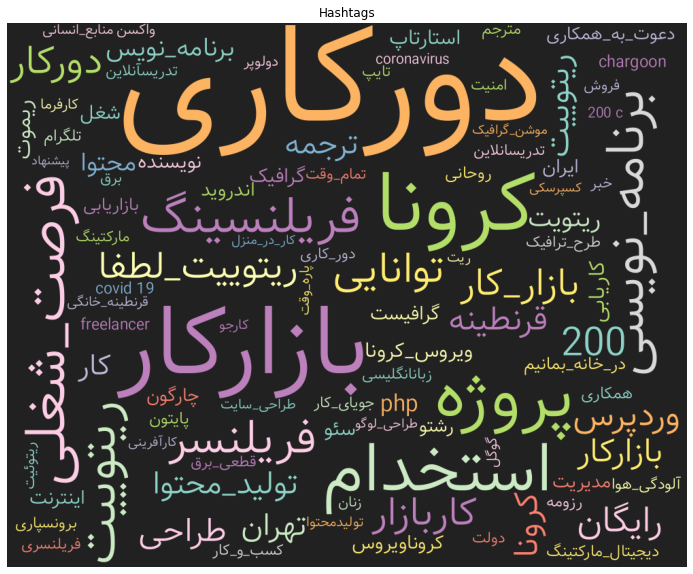

In [23]:
plt.figure(figsize=(20,10))

wc = WordCloudFa(background_color="#212121",
                 no_reshape = True,
                 max_words=100,
                 colormap='Set3', 
                 max_font_size=200,
                 width=1000, 
                 height=800)
wc.generate(" ".join(hashtag_words))
plt.gca().imshow(wc)
plt.gca().set_title('Hashtags', fontdict=dict(size=12))
plt.gca().axis('off')

# Tweets

In [22]:
def get_uni_bi_tri_grams(text):
    tokens = word_tokenize(text)
    
    bigrams = list(ngrams(tokens, 2)) if len(tokens) >= 2 else []
    bigram_tokens = [' '.join(b) for b in bigrams]
    
    trigrams = list(ngrams(tokens, 3)) if len(tokens) >= 3 else []
    trigram_tokens = [' '.join(t) for t in trigrams]
    
    tokens = tokens + bigram_tokens + trigram_tokens
    return tokens

In [23]:
def get_listof_all_tweet_tokens(data_df, col_name):
    col_n_grams = data_df[col_name].progress_apply(lambda t: get_uni_bi_tri_grams(t))
    all_tokens = []
    for index, value in tqdm(col_n_grams.items()):
        all_tokens.extend(value)
    
    random.shuffle(all_tokens)
    
    return all_tokens

## Lemmatized

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 45359/45359 [00:00<00:00, 46282.89it/s]
45359it [00:00, 1018024.49it/s]


(-0.5, 999.5, 799.5, -0.5)

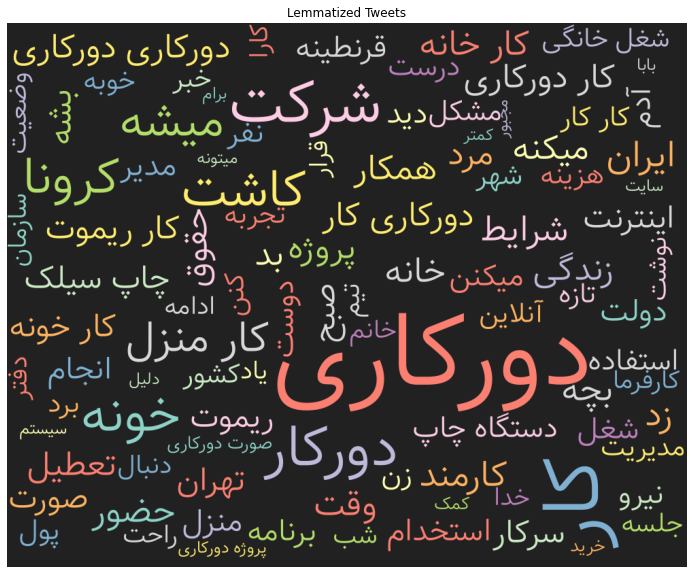

In [98]:
lemmatized_tweets_words = get_listof_all_tweet_tokens(tweets_df, 'lemmatized_tweet')

plt.figure(figsize=(20,10))

wc = WordCloudFa(background_color="#212121",
                 no_reshape = True,
                 max_words=100,
                 colormap='Set3', 
                 max_font_size=150,
                 width=1000, 
                 height=800)
wc.generate(" ".join(lemmatized_tweets_words))
plt.gca().imshow(wc)
plt.gca().set_title('Lemmatized Tweets', fontdict=dict(size=12))
plt.gca().axis('off')

#### Word Frequencies

In [99]:
# Access the words and frequencies
word_frequencies = wc.words_

# Iterate over the words and print them along with their frequencies
for word, frequency in word_frequencies.items():
    print(f"Word: {word}, Frequency: {frequency}")

Word: ÿØŸàÿ±⁄©ÿßÿ±€å, Frequency: 1.0
Word: ⁄©ÿßÿ±, Frequency: 0.5478588154171036
Word: ÿ¥ÿ±⁄©ÿ™, Frequency: 0.28318800189625204
Word: ÿØŸàÿ±⁄©ÿßÿ±, Frequency: 0.2528623349757941
Word: ÿÆŸàŸÜŸá, Frequency: 0.20758213500739825
Word: ⁄©ÿßÿ¥ÿ™, Frequency: 0.1979572194049791
Word: ⁄©ÿ±ŸàŸÜÿß, Frequency: 0.19202424904109983
Word: ŸÖ€åÿ¥Ÿá, Frequency: 0.1774575857263938
Word: ⁄©ÿßÿ± ŸÖŸÜÿ≤ŸÑ, Frequency: 0.1344471419746879
Word: ÿß€åÿ±ÿßŸÜ, Frequency: 0.0954590510120527
Word: ⁄©ÿßÿ±ŸÖŸÜÿØ, Frequency: 0.09010070247518352
Word: ÿ¥ÿ±ÿß€åÿ∑, Frequency: 0.08912384536926635
Word: ÿ≠ÿ∂Ÿàÿ±, Frequency: 0.08777348407579262
Word: ŸáŸÖ⁄©ÿßÿ±, Frequency: 0.08455560184453606
Word: ÿ®⁄ÜŸá, Frequency: 0.08452687075318556
Word: ÿ≤ÿØ, Frequency: 0.08419646320265475
Word: ÿÆÿßŸÜŸá, Frequency: 0.08373676574104667
Word: ⁄©ÿßÿ± ÿÆÿßŸÜŸá, Frequency: 0.08350691701024264
Word: ŸàŸÇÿ™, Frequency: 0.08046142132708911
Word: ŸÖ€å⁄©ŸÜŸá, Frequency: 0.07997299277413053
Word: ÿ®ÿ¥Ÿá, Frequency: 0.07896740457686285
Word: ÿ≠Ÿ

#### English Wordcloud

In [100]:
translate_dict = {}
for word, frequency in wc.words_.items():
    translated_word = translator.translate(word)
    translate_dict[word] = translated_word
    print("word: " + word + ", translate: " + translate_dict[word])

word: ÿØŸàÿ±⁄©ÿßÿ±€å, translate: Remote
word: ⁄©ÿßÿ±, translate: work
word: ÿ¥ÿ±⁄©ÿ™, translate: Company
word: ÿØŸàÿ±⁄©ÿßÿ±, translate: remote work
word: ÿÆŸàŸÜŸá, translate: Home Delivery
word: ⁄©ÿßÿ¥ÿ™, translate: Planting
word: ⁄©ÿ±ŸàŸÜÿß, translate: Krona
word: ŸÖ€åÿ¥Ÿá, translate: mind if i , uh .
word: ⁄©ÿßÿ± ŸÖŸÜÿ≤ŸÑ, translate: home work
word: ÿß€åÿ±ÿßŸÜ, translate: Iran
word: ⁄©ÿßÿ±ŸÖŸÜÿØ, translate: Clerk
word: ÿ¥ÿ±ÿß€åÿ∑, translate: Terms
word: ÿ≠ÿ∂Ÿàÿ±, translate: Being There
word: ŸáŸÖ⁄©ÿßÿ±, translate: Partner
word: ÿ®⁄ÜŸá, translate: Child
word: ÿ≤ÿØ, translate: hit
word: ÿÆÿßŸÜŸá, translate: Home
word: ⁄©ÿßÿ± ÿÆÿßŸÜŸá, translate: factory
word: ŸàŸÇÿ™, translate: When
word: ŸÖ€å⁄©ŸÜŸá, translate: does
word: ÿ®ÿ¥Ÿá, translate: Be it
word: ÿ≠ŸÇŸàŸÇ, translate: Jurisprudence
word: ÿ®ÿØ, translate: Poor
word: ⁄©ÿßÿ± ÿØŸàÿ±⁄©ÿßÿ±€å, translate: remote work
word: ÿØŸàÿ±⁄©ÿßÿ±€å ÿØŸàÿ±⁄©ÿßÿ±€å, translate: Telecommuting Telecommuting
word: ÿ≤ŸÜÿØ⁄Ø€å, translate: Life 
word: ÿØŸàÿ

* word: ÿØŸàÿ±⁄©ÿßÿ±€å - Remote Work
^ word: ⁄©ÿßÿ± - work
^ word: ÿ¥ÿ±⁄©ÿ™ - Company
^ word: ÿØŸàÿ±⁄©ÿßÿ± - remote work
* word: ÿÆŸàŸÜŸá - Home
^ word: ⁄©ÿßÿ¥ÿ™ - Planting
* word: ⁄©ÿ±ŸàŸÜÿß - Coronavirus
* word: ŸÖ€åÿ¥Ÿá - 
* word: ⁄©ÿßÿ± ŸÖŸÜÿ≤ŸÑ - Work from home
^ word: ÿß€åÿ±ÿßŸÜ - Iran
* word: ⁄©ÿßÿ±ŸÖŸÜÿØ - Employee
^ word: ÿ¥ÿ±ÿß€åÿ∑ - Terms
^ word: ÿ≠ÿ∂Ÿàÿ± - Being There
^ word: ŸáŸÖ⁄©ÿßÿ± - Partner
^ word: ÿ®⁄ÜŸá - Child
^ word: ÿ≤ÿØ - hit
^ word: ÿÆÿßŸÜŸá - Home
^ word: ⁄©ÿßÿ± ÿÆÿßŸÜŸá - factory
* word: ŸàŸÇÿ™ - Time
^ word: ŸÖ€å⁄©ŸÜŸá - does
^ word: ÿ®ÿ¥Ÿá - Be it
* word: ÿ≠ŸÇŸàŸÇ - Salary
^ word: ÿ®ÿØ - Poor
^ word: ⁄©ÿßÿ± ÿØŸàÿ±⁄©ÿßÿ±€å - remote work
* word: ÿØŸàÿ±⁄©ÿßÿ±€å ÿØŸàÿ±⁄©ÿßÿ±€å - 
^ word: ÿ≤ŸÜÿØ⁄Ø€å - Life 
^ word: ÿØŸàÿ±⁄©ÿßÿ±€å ⁄©ÿßÿ± - telecommuting work
^ word: ÿ™ÿπÿ∑€åŸÑ - Day Off!
^ word: Ÿæÿ±Ÿà⁄òŸá - Project
^ word: ŸÖÿ±ÿØ - Male
^ word: ⁄©ÿßÿ± ÿ±€åŸÖŸàÿ™ - remote work
^ word: ÿ™Ÿáÿ±ÿßŸÜ - Tehran
^ word: ⁄ÜÿßŸæ ÿ≥€åŸÑ⁄© - Silk print
^ word: ÿµÿ®ÿ≠ - Morni

(-0.5, 999.5, 799.5, -0.5)

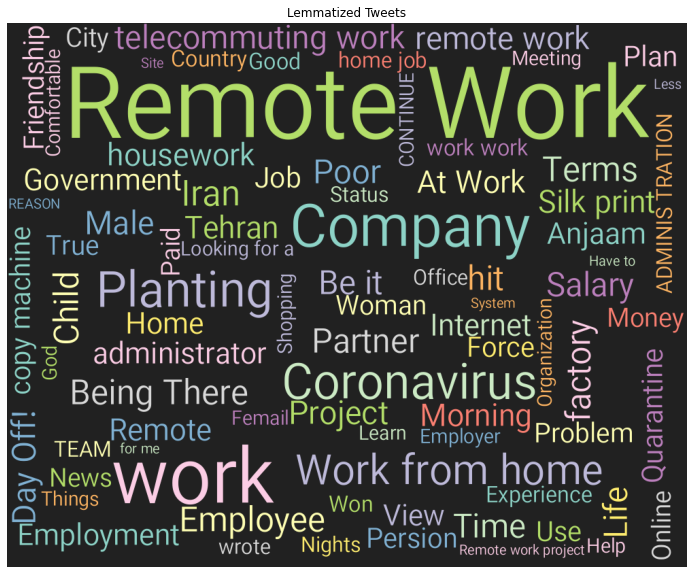

In [101]:
manual_dict = {
    "ÿØŸàÿ±⁄©ÿßÿ±€å": "Remote Work",
    "ÿÆŸàŸÜŸá": "Home",
    "⁄©ÿ±ŸàŸÜÿß": "Coronavirus",
    "⁄©ÿßÿ±ÿß": "Things",
    "ÿ®ÿßÿ®ÿß": "",
    "ÿ≥€åÿ≥ÿ™ŸÖ": "System",
    "ŸÖÿ¨ÿ®Ÿàÿ±": "Have to",
    "€åÿßÿØ": "Learn",
    "ÿ™ÿßÿ≤Ÿá": "",
    "ÿÆŸàÿ®Ÿá": "Good",
    "ÿ≥ÿ±⁄©ÿßÿ±": "At Work",
    "ÿ≤ŸÜ": "Woman",
    "ŸÇÿ±ŸÜÿ∑€åŸÜŸá": "Quarantine",
    "⁄©ÿßÿ±ŸÖŸÜÿØ": "Employee",
    "⁄©ÿßÿ±ŸÅÿ±ŸÖÿß": "Employer",
    "⁄©ÿßÿ± ŸÖŸÜÿ≤ŸÑ": "Work from home",
    "ÿµŸàÿ±ÿ™": "",
    "ŸÖ€åÿ¥Ÿá": "",
    "ÿ¢ÿØŸÖ": "",
    "ÿµŸàÿ±ÿ™ ÿØŸàÿ±⁄©ÿßÿ±€å": "",
    "ŸàŸÇÿ™": "Time",
    "ÿ™ÿ¨ÿ±ÿ®Ÿá": "Experience",
    "ÿÆÿßŸÜŸÖ": "Femail",
    "ÿ≠ŸÇŸàŸÇ": "Salary",
    "ŸÖ€åÿ¥Ÿá": "",
    "ÿØŸàÿ±⁄©ÿßÿ±€å ÿØŸàÿ±⁄©ÿßÿ±€å": "",
    "ÿ±€åŸÖŸàÿ™": "Remote",
    "ŸÖ€å⁄©ŸÜŸÜ": "",
    "ŸÖŸÜÿ≤ŸÑ": "Home",
    "ŸÖ€åÿ™ŸàŸÜŸá": ""
}
word_frequencies = {}
for word, frequency in wc.words_.items():
    try:
        if(word in manual_dict):
            word_frequencies[manual_dict[word]] = frequency
            print("* word: "+word+" - "+manual_dict[word])
        else:
            word_frequencies[translate_dict[word]] = frequency
            print("^ word: "+word+" - "+translate_dict[word])
            
    except Exception as e:
        print(f"Translation failed for word: {word}. Error: {e}")

plt.figure(figsize=(20,10))
wc.generate_from_frequencies(word_frequencies)
plt.gca().imshow(wc)
plt.gca().set_title('Lemmatized Tweets', fontdict=dict(size=12))
plt.gca().axis('off')

In [ ]:
# Access the words and frequencies
word_frequencies = wc.words_

# Iterate over the words and print them along with their frequencies
for word, frequency in word_frequencies.items():
    print(f"Word: {word}, Frequency: {frequency}")

## Non-Lemmatized

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 45359/45359 [00:02<00:00, 18777.00it/s]
45359it [00:00, 596621.39it/s]


(-0.5, 999.5, 799.5, -0.5)

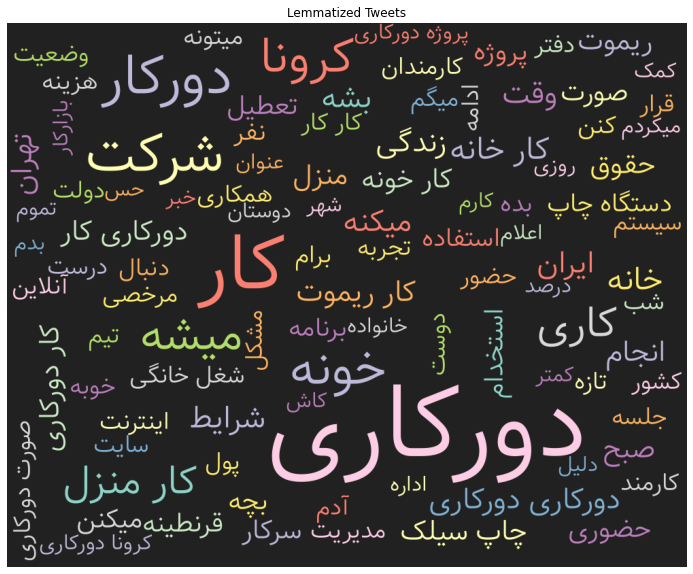

In [27]:
non_lemmatized_tweets_words = get_listof_all_tweet_tokens(tweets_df, 'tweet')

plt.figure(figsize=(20,10))

wc = WordCloudFa(background_color="#212121",
                 no_reshape = True,
                 max_words=100,
                 colormap='Set3', 
                 max_font_size=150,
                 width=1000, 
                 height=800)
wc.generate(" ".join(non_lemmatized_tweets_words))
plt.gca().imshow(wc)
plt.gca().set_title('Non-Lemmatized Tweets', fontdict=dict(size=12))
plt.gca().axis('off')

In [28]:
tweets_df["tweet"].head(10)

0    ⁄Øÿ≤ÿßÿ±ÿ¥ ÿ≠ŸÇŸàŸÇÿ¥ ŸÖ€åÿØŸàŸÜŸÖ ÿ≥ÿßŸÑ€å €∏€µ ŸáŸÖÿ≥ÿ±ÿ¥ ÿØÿßŸÜÿ¥ÿ¨Ÿà ÿØ⁄©ÿ™ÿ±ÿß ÿ¥ÿ±⁄©ÿ™ ÿßÿ≠ÿ™ŸÖÿßŸÑŸÜ ŸÖÿ¥ÿßŸàÿ± ŸÖŸàÿ±⁄Øÿ¨ ÿ®ÿ±ÿßÿ¥ ŸÖÿØÿßÿ±⁄© ÿ≠ŸÇŸàŸÇ ÿØÿ±€åÿßŸÅÿ™€å ÿØÿ±ÿ≥ÿ™ ÿØÿ±ÿÆŸàÿßÿ≥ÿ™ ŸàÿßŸÖ €π€µ€∞ ÿ™ÿß€å€åÿ¥ ŸÇÿ®ŸàŸÑ ÿ±€åÿ≥⁄©ÿ¥ ÿ¨ÿßŸÑÿ® ŸÖÿ∑ŸÖ€åŸÜŸá ŸÇÿ±ÿßÿ±ÿØÿßÿØÿ¥ ÿ™ŸÖÿØ€åÿØ ŸÖ€åÿ¥Ÿá ⁄©ÿßÿ± ÿÆŸàŸÜŸá ÿßÿØÿßŸÖŸá ŸÖ€å⁄©ŸÜŸá
1                                                                                                                        ÿß€åŸÜÿß€å€å ÿ≥ŸÅÿ± ŸÖŸáŸÖŸàŸÜ€å Ÿæÿ±Ÿàÿ™⁄©ŸÑ€å ÿ±ÿπÿß€åÿ™ ŸÜ⁄©ÿ±ÿØŸÜ ÿ≥ÿ±⁄©ÿßÿ± ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá ÿØŸàÿ±⁄©ÿßÿ± ÿ®ÿ¥€åŸÖ ÿ®Ÿáÿ™ÿ±Ÿá
2            ÿÆÿ≥ÿ™Ÿá ÿØŸàÿ±⁄©ÿßÿ±€å ÿ¥Ÿáÿ±Ÿáÿß€å ÿ≥ÿ±ŸàÿµÿØÿß ÿ¥ÿ® ÿßÿ≤ÿµÿ®ÿ≠ ÿ¢ÿ≤ÿßÿ±ÿØŸáŸÜÿØŸá ÿ™ÿ±Ÿá ŸÜÿ®ŸàÿØŸÅÿ±ŸáŸÜ⁄Ø ÿ¥Ÿáÿ±ŸÜÿ¥€åŸÜ€å ÿ¢Ÿæÿßÿ±ÿ™ŸÖÿßŸÜ ŸÜÿ¥€åŸÜ€å ÿ®€åÿØÿßÿØ ŸÖ€å⁄©ŸÜŸá ŸáŸÖ⁄Ø€å ÿ±ÿπÿß€åÿ™ ŸáŸÖÿØ€å⁄Øÿ± ⁄Üÿßÿ±ÿØ€åŸàÿßÿ±€å ÿßÿÆÿ™€åÿßÿ±€å ŸÖÿ±ÿØŸÖÿØÿßÿ±€å ⁄ØŸàÿ¥Ÿá ÿßÿ≤ŸÅÿ±ŸáŸÜ⁄Ø Ÿàÿ¥ÿπŸàÿ± ŸàÿßŸÜÿ≥ÿßŸÜ€åÿ™Ÿá ÿ¥ÿ® ÿÆŸàÿ¥üåÉ
3                                                           

In [30]:
base_path = "../data/"
input_file = base_path + "remote_tweets.csv"

reader = pd.read_csv(input_file)
reader.head(20)

/tmp/ipykernel_736/252964057.py:4: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  reader = pd.read_csv(input_file)


conversation_id  retweets_count  \
0   1375557622410149894               2   
1   1375559420176908296               3   
2   1383828354197979136               2   
3   1383840315031781385               0   
4   1383820625354002439               1   
5   1383830770125443083               0   
6   1381125763672461313               0   
7   1382520237359308801               0   
8   1382908294826692609               0   
9   1379296978895523840               0   
10  1379296190114623496               0   
11  1379296190114623496               0   
12  1379291584383049729               0   
13  1379286871721844736               0   
14  1379151122334687233               0   
15  1379294966271242240               1   
16  1379294257941471235               1   
17  1384543523572232193               0   
18  1380208498466816007               0   
19  1384079495263522817               0   

                                          mentions                 created_at  \
0                                              NaN  2021-03-26 21:23:21+00:00   
1                                              NaN  2021-03-26 21:24:57+00:00   
2                                              NaN  2021-04-18 17:02:44+00:00   
3                                              NaN  2021-04-18 17:50:16+00:00   
4                                     ['15782990']  2021-04-18 17:31:42+00:00   
5                                              NaN  2021-04-18 17:12:20+00:00   
6                          ['1356685682576613378']  2021-04-16 07:20:49+00:00   
7   ['1133806003949117441', '1200090978566230016']  2021-04-16 07:23:26+00:00   
8            ['1215875512045838337', '1240664911']  2021-04-16 07:15:38+00:00   
9                                              NaN  2021-04-06 04:56:40+00:00   
10                                             NaN  2021-04-06 04:53:32+00:00   
11                         ['1102426504531795969']  2021-04-06 04:56:21+00:00   
12                                             NaN  2021-04-06 04:35:14+00:00   
13                                             NaN  2021-04-06 04:16:30+00:00   
14                          ['975653244549689347']  2021-04-06 04:12:53+00:00   
15                                             NaN  2021-04-06 04:48:40+00:00   
16                                             NaN  2021-04-06 04:45:51+00:00   
17                                             NaN  2021-04-20 16:24:34+00:00   
18                                             NaN  2021-04-09 01:54:50+00:00   
19                                             NaN  2021-04-19 09:40:41+00:00   

    likes_count  in_reply_to_user_id                  _id  \
0           111         5.720514e+08  1375559020451356674   
1           163                  NaN  1375559420176908296   
2            37                  NaN  1383828354197979136   
3            11                  NaN  1383840315031781385   
4             9         1.578299e+07  1383835643239747593   
5             8                  NaN  1383830770125443083   
6             1         1.356686e+18  1382957135315763200   
7             3         1.133806e+18  1382957792726777860   
8            22         1.215876e+18  1382955827905052673   
9             8                  NaN  1379296978895523840   
10           30                  NaN  1379296190114623496   
11            1         1.102427e+18  1379296898683695104   
12           12                  NaN  1379291584383049729   
13           11                  NaN  1379286871721844736   
14            0         9.756532e+17  1379285958961598466   
15           75                  NaN  1379294966271242240   
16           72                  NaN  1379294257941471235   
17           11                  NaN  1384543523572232193   
18            0         1.070834e+18  1380338383432646659   
19            3                  NaN  1384079495263522817   

                 source              user_id  in_reply_to_status_id  \
0    Twitter for iPhone            572051429     

In [31]:
reader.head(20)

conversation_id  retweets_count  \
0   1375557622410149894               2   
1   1375559420176908296               3   
2   1383828354197979136               2   
3   1383840315031781385               0   
4   1383820625354002439               1   
5   1383830770125443083               0   
6   1381125763672461313               0   
7   1382520237359308801               0   
8   1382908294826692609               0   
9   1379296978895523840               0   
10  1379296190114623496               0   
11  1379296190114623496               0   
12  1379291584383049729               0   
13  1379286871721844736               0   
14  1379151122334687233               0   
15  1379294966271242240               1   
16  1379294257941471235               1   
17  1384543523572232193               0   
18  1380208498466816007               0   
19  1384079495263522817               0   

                                          mentions                 created_at  \
0                                              NaN  2021-03-26 21:23:21+00:00   
1                                              NaN  2021-03-26 21:24:57+00:00   
2                                              NaN  2021-04-18 17:02:44+00:00   
3                                              NaN  2021-04-18 17:50:16+00:00   
4                                     ['15782990']  2021-04-18 17:31:42+00:00   
5                                              NaN  2021-04-18 17:12:20+00:00   
6                          ['1356685682576613378']  2021-04-16 07:20:49+00:00   
7   ['1133806003949117441', '1200090978566230016']  2021-04-16 07:23:26+00:00   
8            ['1215875512045838337', '1240664911']  2021-04-16 07:15:38+00:00   
9                                              NaN  2021-04-06 04:56:40+00:00   
10                                             NaN  2021-04-06 04:53:32+00:00   
11                         ['1102426504531795969']  2021-04-06 04:56:21+00:00   
12                                             NaN  2021-04-06 04:35:14+00:00   
13                                             NaN  2021-04-06 04:16:30+00:00   
14                          ['975653244549689347']  2021-04-06 04:12:53+00:00   
15                                             NaN  2021-04-06 04:48:40+00:00   
16                                             NaN  2021-04-06 04:45:51+00:00   
17                                             NaN  2021-04-20 16:24:34+00:00   
18                                             NaN  2021-04-09 01:54:50+00:00   
19                                             NaN  2021-04-19 09:40:41+00:00   

    likes_count  in_reply_to_user_id                  _id  \
0           111         5.720514e+08  1375559020451356674   
1           163                  NaN  1375559420176908296   
2            37                  NaN  1383828354197979136   
3            11                  NaN  1383840315031781385   
4             9         1.578299e+07  1383835643239747593   
5             8                  NaN  1383830770125443083   
6             1         1.356686e+18  1382957135315763200   
7             3         1.133806e+18  1382957792726777860   
8            22         1.215876e+18  1382955827905052673   
9             8                  NaN  1379296978895523840   
10           30                  NaN  1379296190114623496   
11            1         1.102427e+18  1379296898683695104   
12           12                  NaN  1379291584383049729   
13           11                  NaN  1379286871721844736   
14            0         9.756532e+17  1379285958961598466   
15           75                  NaN  1379294966271242240   
16           72                  NaN  1379294257941471235   
17           11                  NaN  1384543523572232193   
18            0         1.070834e+18  1380338383432646659   
19            3                  NaN  1384079495263522817   

                 source              user_id  in_reply_to_status_id  \
0    Twitter for iPhone            572051429     

In [32]:
reader.drop("hashtags", axis=1, inplace=True)
reader.drop("tweet", axis=1, inplace=True)
reader

conversation_id  retweets_count                 mentions  \
0      1375557622410149894               2                      NaN   
1      1375559420176908296               3                      NaN   
2      1383828354197979136               2                      NaN   
3      1383840315031781385               0                      NaN   
4      1383820625354002439               1             ['15782990']   
...                    ...             ...                      ...   
45354  1434127275587428352               0  ['1273546506012897281']   
45355  1434127961943326723               0  ['1251428296589488129']   
45356  1434138057071112194               0                      NaN   
45357  1434133064750338048               0                      NaN   
45358  1434121611561558016               0  ['1307304359458418689']   

                      created_at  likes_count  in_reply_to_user_id  \
0      2021-03-26 21:23:21+00:00          111         5.720514e+08   
1      2021-03-26 21:24:57+00:00          163                  NaN   
2      2021-04-18 17:02:44+00:00           37                  NaN   
3      2021-04-18 17:50:16+00:00           11                  NaN   
4      2021-04-18 17:31:42+00:00            9         1.578299e+07   
...                          ...          ...                  ...   
45354  2021-09-04 12:46:01+00:00            3         1.273547e+18   
45355  2021-09-04 12:21:54+00:00            2         1.251428e+18   
45356  2021-09-04 12:55:32+00:00            4                  NaN   
45357  2021-09-04 12:35:42+00:00           18                  NaN   
45358  2021-09-04 12:02:55+00:00            1         1.307304e+18   

                       _id               source              user_id  \
0      1375559020451356674   Twitter for iPhone            572051429   
1      1375559420176908296   Twitter for iPhone   812764546012246017   
2      1383828354197979136  Twitter for Android   985101690536898565   
3      1383840315031781385      Twitter Web App            310871673   
4      1383835643239747593      Twitter Web App  1271095835028307969   
...                    ...                  ...                  ...   
45354  1434135662396018689  Twitter for Android  1260775960267444225   
45355  1434129593036939267  Twitter for Android  1214804130096668672   
45356  1434138057071112194   Twitter for iPhone  1147481863138811905   
45357  1434133064750338048  Twitter for Android  1106832761216815104   
45358  1434124815330418691  Twitter for Android  1405163447352975369   

       in_reply_to_status_id  replies_count  quoted_status_id cashtags urls  
0               1.375558e+18              3               NaN      NaN  NaN  
1                        NaN              1               NaN      NaN  NaN  
2                        NaN              3               NaN      NaN  NaN  
3                        NaN              1      1.383657e+18      NaN  NaN  
4               1.383821e+18              1               NaN      NaN  NaN  
...                      ...            ...               ...      ...  ...  
45354           1.434127e+18              0               NaN      NaN  NaN  
45355           1.434128e+18              1               NaN      NaN  NaN  
45356                    NaN              0               NaN      NaN  NaN  
45357                    NaN              0               NaN      NaN  NaN  
45358           1.434122e+18              1               NaN      NaN  NaN  

[45359 rows x 14 columns]

In [33]:
preprocessed_df = pd.concat([reader, tweets_df[['tweet', 'hashtags', 'tweet_tokens', 'lemmatized_tweet', 'lemmatized_tweet_token', 'tweet_size', 'lemmatized_tweet_size']]], axis = 1)

In [34]:
# pd.set_option('display.max_rows', 1000)
with pd.option_context('display.max_rows', None, ):
    print(preprocessed_df["tweet"].head(20))

0     ⁄Øÿ≤ÿßÿ±ÿ¥ ÿ≠ŸÇŸàŸÇÿ¥ ŸÖ€åÿØŸàŸÜŸÖ ÿ≥ÿßŸÑ€å €∏€µ ŸáŸÖÿ≥ÿ±ÿ¥ ÿØÿßŸÜÿ¥ÿ¨Ÿà ÿØ⁄©ÿ™ÿ±ÿß ÿ¥ÿ±⁄©ÿ™ ÿßÿ≠ÿ™ŸÖÿßŸÑŸÜ ŸÖÿ¥ÿßŸàÿ± ŸÖŸàÿ±⁄Øÿ¨ ÿ®ÿ±ÿßÿ¥ ŸÖÿØÿßÿ±⁄© ÿ≠ŸÇŸàŸÇ ÿØÿ±€åÿßŸÅÿ™€å ÿØÿ±ÿ≥ÿ™ ÿØÿ±ÿÆŸàÿßÿ≥ÿ™ ŸàÿßŸÖ €π€µ€∞ ÿ™ÿß€å€åÿ¥ ŸÇÿ®ŸàŸÑ ÿ±€åÿ≥⁄©ÿ¥ ÿ¨ÿßŸÑÿ® ŸÖÿ∑ŸÖ€åŸÜŸá ŸÇÿ±ÿßÿ±ÿØÿßÿØÿ¥ ÿ™ŸÖÿØ€åÿØ ŸÖ€åÿ¥Ÿá ⁄©ÿßÿ± ÿÆŸàŸÜŸá ÿßÿØÿßŸÖŸá ŸÖ€å⁄©ŸÜŸá
1                                                                                                                         ÿß€åŸÜÿß€å€å ÿ≥ŸÅÿ± ŸÖŸáŸÖŸàŸÜ€å Ÿæÿ±Ÿàÿ™⁄©ŸÑ€å ÿ±ÿπÿß€åÿ™ ŸÜ⁄©ÿ±ÿØŸÜ ÿ≥ÿ±⁄©ÿßÿ± ÿÆÿ∑ÿ±ŸÜÿß⁄©Ÿá ÿØŸàÿ±⁄©ÿßÿ± ÿ®ÿ¥€åŸÖ ÿ®Ÿáÿ™ÿ±Ÿá
2             ÿÆÿ≥ÿ™Ÿá ÿØŸàÿ±⁄©ÿßÿ±€å ÿ¥Ÿáÿ±Ÿáÿß€å ÿ≥ÿ±ŸàÿµÿØÿß ÿ¥ÿ® ÿßÿ≤ÿµÿ®ÿ≠ ÿ¢ÿ≤ÿßÿ±ÿØŸáŸÜÿØŸá ÿ™ÿ±Ÿá ŸÜÿ®ŸàÿØŸÅÿ±ŸáŸÜ⁄Ø ÿ¥Ÿáÿ±ŸÜÿ¥€åŸÜ€å ÿ¢Ÿæÿßÿ±ÿ™ŸÖÿßŸÜ ŸÜÿ¥€åŸÜ€å ÿ®€åÿØÿßÿØ ŸÖ€å⁄©ŸÜŸá ŸáŸÖ⁄Ø€å ÿ±ÿπÿß€åÿ™ ŸáŸÖÿØ€å⁄Øÿ± ⁄Üÿßÿ±ÿØ€åŸàÿßÿ±€å ÿßÿÆÿ™€åÿßÿ±€å ŸÖÿ±ÿØŸÖÿØÿßÿ±€å ⁄ØŸàÿ¥Ÿá ÿßÿ≤ŸÅÿ±ŸáŸÜ⁄Ø Ÿàÿ¥ÿπŸàÿ± ŸàÿßŸÜÿ≥ÿßŸÜ€åÿ™Ÿá ÿ¥ÿ® ÿÆŸàÿ¥üåÉ
3                                                        

In [35]:
preprocessed_df.to_csv('../data/preprocessed.csv', index=False)